In [28]:
import os, sys
from os.path import join

import nibabel as nib
import numpy as np
import pandas as pd

from nilearn.image import index_img
from nilearn.image import load_img
from nilearn.image import mean_img
from nilearn.image import new_img_like
from nilearn.masking import apply_mask

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Multivoxel approaches
This notebook explores whether we can build a multivoxel model for predicting the trial state (REST, MOTOR, IMAGERY) based on the first run of data, and then apply that model to subsequent runs. 


# Prep Inputs

In [29]:
# load timing files
trialOnsets = pd.read_csv('../data/subject001/timingFiles/trialOnsets.tsv', sep='\t')
trialOnsets

,onsets_TR1,onsets_TR2,trialTypes,weights,duration
0,4,2,rest,1.0,20
1,24,22,motor,1.0,10
2,34,32,rest,1.0,20
3,54,52,imagery,1.0,10
4,64,62,rest,1.0,20
5,84,82,imagery,1.0,10
6,94,92,rest,1.0,20
7,114,112,motor,1.0,10
8,124,122,rest,1.0,20
9,144,142,imagery,1.0,10


In [122]:
# task labels
labels_1s = np.array(['nan'] * 186, dtype=object)
labels_1s_exclude2 = np.array(['nan'] * 186, dtype=object)
labels_2s = np.array(['nan'] * 93, dtype=object)

#loop over trialOnsets to populate labels arrays
for i,row in trialOnsets.iterrows():
    # 1s TRs
    startIdx = row['onsets_TR1']
    endIdx = startIdx + row['duration']+1
    labels_1s[startIdx:endIdx] = row['trialTypes']
    
    # 1s TRs, exclude 2s
    startIdx = row['onsets_TR1'] + 2
    endIdx = startIdx + row['duration'] - 2
    labels_1s_exclude2[startIdx:endIdx] = row['trialTypes']
    
    # 2s TRs
    startIdx = row['onsets_TR2']/2
    endIdx = startIdx + row['duration']/2 + 1
    labels_2s[int(startIdx):int(endIdx)] = row['trialTypes']
    
# convert to pandas series
labels_1s = pd.Series(labels_1s)
labels_1s_exclude2 = pd.Series(labels_1s_exclude2)
labels_2s = pd.Series(labels_2s)

We now have two arrays representing timept labels for each TR type (i.e. 1s vs 2s):
* **labels_1s**: timept labels for each volume in the 1s TR runs
* **labels_1s_exclude2**: timept labels for each volume, excluding 2s of "transition" around each trial switch
* **labels_2s**: timept labels for each volume in the 2s TR runs

# First run model, Motor vs Rest

Try to train a classifier to accurately predict REST from MOTOR timepts based on the first run ONLY

**Goal:** Find the mask and model parameters that yield the maximum classification accuracy between MOTOR and REST timepts

Using an SVM binary classifier, we'll train/test the model using Kfold cross validation with features obtained from the following masks:
* functionally defined (5mm sphere around peak for MOTOR>REST contrast)
* anatomically defined (full L primary motor cortex)
* anatomically defined (L primary motor cortext thresholded at >50% prob)
* whole brain

For each mask, we'll compute classification accuracy for:
* all MOTOR and REST volumes
* exclude 2s of "transition" volumes between each trial

In [113]:
# import necessary libraries
from nilearn.input_data import NiftiMasker
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

from nilearn import plotting
from nilearn.plotting import plot_stat_map, show

In [142]:
# build a function to compute mean cross validation score for a given mask and condition label vector
def runClassification(mask, labels):
    """
    inputs:
        - mask: path to the mask file 
        - labels: a 1xNumTimepts array of timept labels 
    """
    
    # set up masker based on the mask
    masker = NiftiMasker(mask_img=mask, standardize=True)
    
    # load fMRI corresponding to voxels within mask
    fmri = masker.fit_transform('../data/subject001/pyneal_002/receivedFunc.nii.gz')
    
    # create an array mask for the conditions of interest
    conditions_mask = labels.isin(['rest', 'motor'])
    
    # grab only the fMRI data timepts that we're interested in
    fmri = fmri[conditions_mask]
    
    # mask the labels vector to match
    labels = labels[conditions_mask]
    
    # build the SVM decoder
    svc = SVC(kernel='linear', C=100)
    
    # set up cross-validator
    cv = KFold(n=len(fmri), n_folds=5)
    
    # run cross-validation
    cv_score = cross_val_score(svc, fmri, labels, cv=cv)
    
    return cv_score
    
    print('{} - mean accuracy: {}, stdDev: {}'.format(os.path.split(mask)[-1], np.mean(cv_score), np.std(cv_score)))

In [148]:
masks = ['motorSphere_5mm_FUNC_mask.nii.gz',
         'motorCortex_FUNC_mask.nii.gz',
         'motorCortex_50prob_FUNC_mask.nii.gz',
         'wholeBrain_FUNC_mask.nii.gz']

allResults = pd.DataFrame(columns=['mask', 'labels', 'meanAcc', 'stdDev'])

for mask in masks:
    for labels in ['all', 'exclude2']:
        # full path to mask file
        maskFile = join('../data/subject001/pyneal_002/mask_transforms/FUNC_masks', mask)
        
        # set the correct labels var
        if labels == 'all':
            theseLabels = labels_1s
        elif labels == 'exclude2':
            theseLabels = labels_1s_exclude2
            
        cv_scores = runClassification(maskFile, theseLabels)
        
        # add results to dataframe
        allResults = allResults.append({'mask': mask, 
                                     'labels': labels, 
                                     'meanAcc': np.mean(cv_scores), 
                                     'stdDev': np.std(cv_scores)}, ignore_index=True)
                         
allResults
        

,mask,labels,meanAcc,stdDev
0,motorSphere_5mm_FUNC_mask.nii.gz,all,0.861720,0.082855
1,motorSphere_5mm_FUNC_mask.nii.gz,exclude2,0.962393,0.033777
2,motorCortex_FUNC_mask.nii.gz,all,0.888602,0.098900
3,motorCortex_FUNC_mask.nii.gz,exclude2,0.925071,0.077562
4,motorCortex_50prob_FUNC_mask.nii.gz,all,0.835269,0.075638
5,motorCortex_50prob_FUNC_mask.nii.gz,exclude2,0.894302,0.072054
6,wholeBrain_FUNC_mask.nii.gz,all,0.875484,0.114390
7,wholeBrain_FUNC_mask.nii.gz,exclude2,0.909687,0.076423


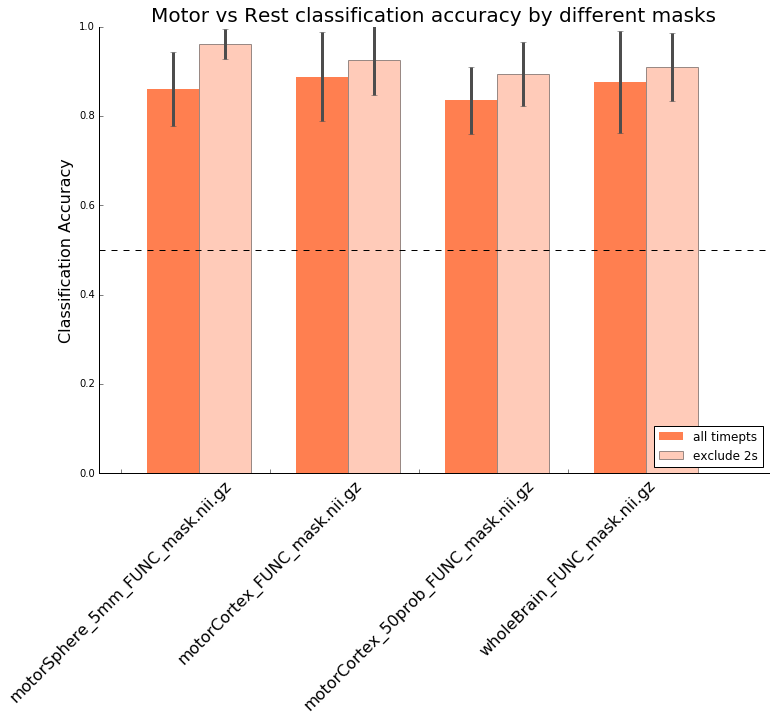

In [205]:
xInd = np.arange(4)
width = 0.35

fig,ax = plt.subplots(figsize=(12,8))
error_config = {'ecolor': '0.3', 'lw':3}

# all timepoints plot
allTmpts = allResults.loc[allResults['labels'] == 'all']
rects1 = ax.bar(xInd-width/2, 
                allTmpts['meanAcc'], 
                width, 
                yerr=allTmpts['stdDev'],
                error_kw=error_config,
                color='coral',
                edgecolor='none',
                label='all timepts')


# exclude 2s plot
exclude2 = allResults.loc[allResults['labels'] == 'exclude2']
rects2 = ax.bar(xInd+width/2,
               exclude2['meanAcc'],
               width,
               yerr=exclude2['stdDev'],
               error_kw=error_config,
               color='coral',
               alpha=.4,
               edgecolor='none',
               label='exclude 2s')

ax.axhline(y=.5, color='k', ls='--')

# format plot
ax.set_ylabel('Classification Accuracy', fontsize=16)
ax.set_ylim([0,1])
ax.set_title('Motor vs Rest classification accuracy by different masks', fontsize=20)
ax.set_xticks(xInd-width)
ax.set_xticklabels(masks, rotation=45, fontsize=16)
ax.legend(loc=4)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(top='off', right='off')

# Test model on subsequent runs

The best model was the one using the **motorSphere_5mm_FUNC_mask.nii.gz** mask and the **exclude 2s** labels. Take this model, and test it on other runs

In [234]:
mask = 'motorSphere_5mm_FUNC_mask.nii.gz'

# check how many voxels are in the masks for each run (given that there was different coverage areas afterall)
for run in ['002', '003', '004', '005']:
    mask_img = load_img(join('../data/subject001/pyneal_{}/mask_transforms/FUNC_masks'.format(run), mask))

    print('run_{} - {} voxels'.format(run, int(sum(mask_img.get_data()))))

run_002 - 63 voxels
run_003 - 68 voxels
run_004 - 63 voxels
run_005 - 58 voxels


In [274]:
maskPath =  join('../data/subject001/pyneal_002/mask_transforms/FUNC_masks', mask)
labels = labels_1s_exclude2

## recreate the model
# set up masker based on the mask
masker = NiftiMasker(mask_img=maskPath, standardize=True)

# load fMRI corresponding to voxels within mask
run1 = masker.fit_transform('../data/subject001/pyneal_002/receivedFunc.nii.gz')

# since the 4th run only has 58 voxels in the mask, truncate this data to the first 58 voxels only
run1 = run1[:, :58]

# create an array mask for the conditions of interest
conditions_mask = labels.isin(['rest', 'motor'])

# grab only the fMRI data timepts that we're interested in
run1_masked = run1[conditions_mask]

# mask the labels vector to match
labels = labels[conditions_mask]

# build the SVM classifier
clf = SVC(kernel='linear', C=100, probability=True)
clf.fit(run1_masked, labels)

# just for fun, run cross-validation using this smaller masked dataset just to make sure accuracy is still good
#clf = SVC(kernel='linear', C=100, probability=True)
cv = KFold(n=len(run1_masked), n_folds=5)
cv_score = cross_val_score(clf, run1_masked, labels, cv=cv)
print(cv_score)

[ 0.92592593  1.          1.          0.92307692  0.96153846]


## Write a function to run each timept through the classifier

In [295]:
def classifyRun(run, mask, clf):
    
    # path to the mask
    maskPath =  '../data/subject001/{}/mask_transforms/FUNC_masks/{}'.format(run, mask)
    masker = NiftiMasker(mask_img=maskPath, standardize=True)
    
    # load the run data
    fmri = masker.fit_transform('../data/subject001/{}/receivedFunc.nii.gz'.format(run))
    
    # truncate to the first 58 voxels only
    fmri = fmri[:, :58]
    
    # empty vars to store class prediction and probability
    predicted_class = []
    predicted_prob = []
    
    # loop over each timept
    for sampleIdx in range(fmri.shape[0]):
        # grab this sample
        sample = fmri[sampleIdx, :].reshape(1,fmri.shape[1])  # reshape to (1,nFeatures)

        # predict class
        predicted_class.append(clf.predict(sample)[0])
        
        # report the probability it's a motor trial
        motorIdx = np.where(clf.classes_ == 'motor')[0][0]   # get the index of where the motor prob will be
        motorProb = clf.predict_proba(sample)[motorIdx][0]
        predicted_prob.append(motorProb)
        
    return np.array(predicted_class), np.array(predicted_prob)
    
        

In [296]:
run = 'pyneal_003'

predictedClasses, predictedProb = classifyRun(run, mask, clf)

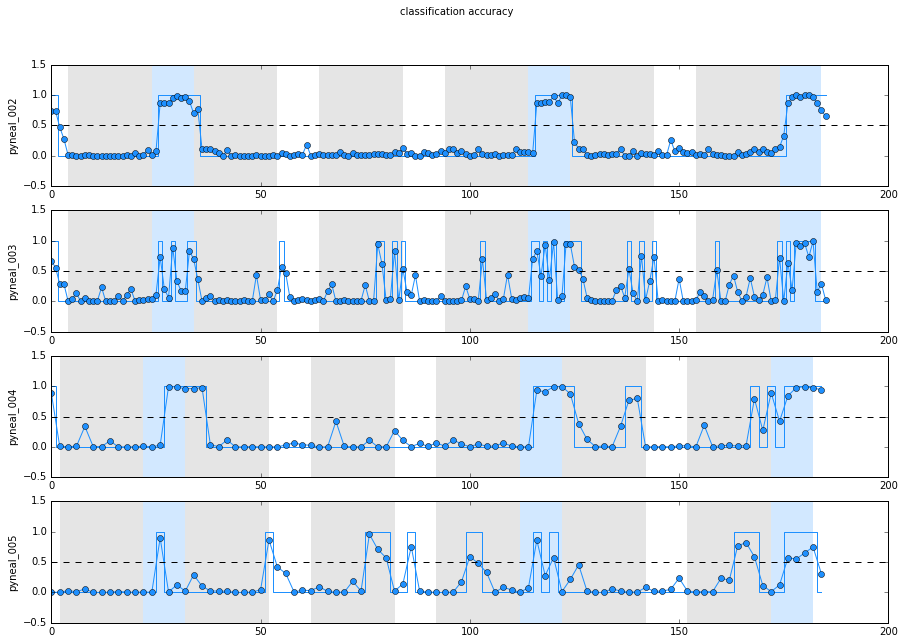

In [311]:
trialType = 'motor'

fig, axs = plt.subplots(4,1, figsize=(15,10))
plt.suptitle('classification accuracy')

for i,run in enumerate(['pyneal_002', 'pyneal_003', 'pyneal_004', 'pyneal_005']):
    
    # get the predicted classes and prediction probabilities for this run
    classes, probs = classifyRun(run, mask, clf)
    
    # plot
    if run in ['pyneal_002', 'pyneal_003']:
        # use 1s TR
        x = np.arange(0,186,1)
        
        # get onsets for trials
        restOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'rest', ['onsets_TR1','duration']]
        restOnsets.rename(index=str, columns={"onsets_TR1":"onsets"}, inplace=True)
        taskOnsets = trialOnsets.loc[trialOnsets.trialTypes == trialType, ['onsets_TR1', 'duration']]
        taskOnsets.rename(index=str, columns={"onsets_TR1":"onsets"}, inplace=True)
        
    else:
        # use 2s TR
        x = np.arange(0,186,2)

        # get onsets for trials
        restOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'rest', ['onsets_TR2','duration']]
        restOnsets.rename(index=str, columns={"onsets_TR2":"onsets"}, inplace=True)
        taskOnsets = trialOnsets.loc[trialOnsets.trialTypes == trialType, ['onsets_TR2', 'duration']]
        taskOnsets.rename(index=str, columns={"onsets_TR2":"onsets"}, inplace=True)
        
    axs[i].set(ylabel=run)
    
    # set span color
    if trialType == 'motor':
        spanColor = 'dodgerblue'
        lineColor = 'dodgerblue'
    elif trialType == 'imagery':
        spanColor = 'goldenrod'
        lineColor = 'goldenrod'
    
    # draw the spans
    for r,row in restOnsets.iterrows():
        onset = row['onsets']
        axs[i].axvspan(onset, onset+row['duration'], facecolor='gray', edgecolor='none', alpha=0.2)

    for r,row in taskOnsets.iterrows():
        onset = row['onsets']
        axs[i].axvspan(onset, onset+row['duration'], facecolor=spanColor, edgecolor='none', alpha=0.2)
        
    # draw the predicted class
    axs[i].step(x, y=np.array(classes == 'motor', dtype=int), where='mid', color='dodgerblue')
    
    # draw the prediction probability
    axs[i].plot(x, np.array(probs), '-o', color='dodgerblue')
    
    # format plot
    axs[i].axhline(y=.5, color='k', ls='--')
    axs[i].set_ylim(-.5, 1.5)
    
    

# save and reload classifier
try to save the classifier as a pickle object, and then reload and test it

In [313]:
import pickle

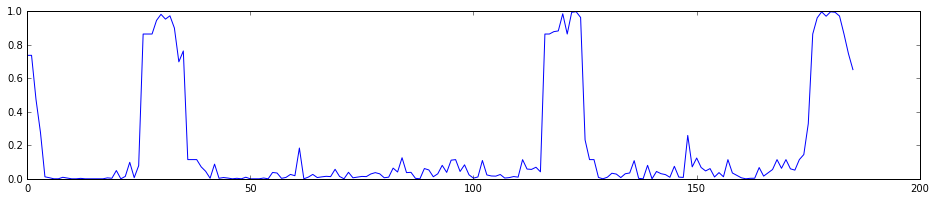

In [325]:
# comparison data for after saving and reloading the classifier 
classes, probs = classifyRun('pyneal_002', mask, clf)

plt.figure(figsize=(16,3))
plt.plot(probs)

In [333]:
# save the classifier
with open('../pynealAnalysis/pyneal_002_classifier.pkl', 'wb') as p:
    pickle.dump(clf, p, pickle.HIGHEST_PROTOCOL)

In [329]:
!ls

subject001_ROIanalyses.ipynb subject001_multivoxel.ipynb
subject001_multivoxel.html   testClassifier.pkl


In [331]:
with open('testClassifier.pkl', 'rb') as p:
    newClf = pickle.load(p)

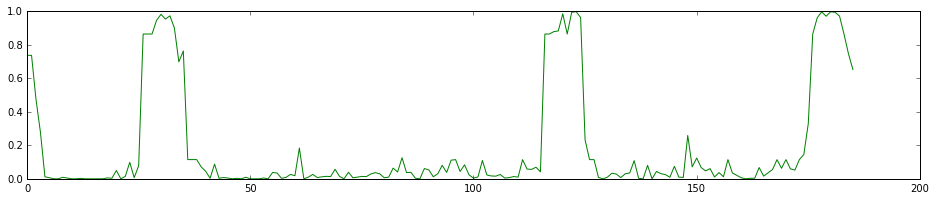

In [332]:
newClasses, newProbs = classifyRun('pyneal_002', mask, newClf)

plt.figure(figsize=(16,3))
plt.plot(probs, 'g-')

Good, confirms saving and loading a trained classifier will work